In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.18.0-dev20240614


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kelvin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_json("E:/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [3]:
del df['article_link']
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [4]:
lab_to_sarcasm = {0:"Not Sarcastic", 1:"Sarcastic"}
def label_decoder(label):
  return lab_to_sarcasm[label]
df.is_sarcastic = df.is_sarcastic.apply(lambda x: label_decoder(x))
df.head()

,is_sarcastic,headline
0,Sarcastic,thirtysomething scientists unveil doomsday clo...
1,Not Sarcastic,dem rep. totally nails why congress is falling...
2,Not Sarcastic,eat your veggies: 9 deliciously different recipes
3,Sarcastic,inclement weather prevents liar from getting t...
4,Sarcastic,mother comes pretty close to using word 'strea...


Text(0.5, 1.0, 'Sarcasm Data Distribution')

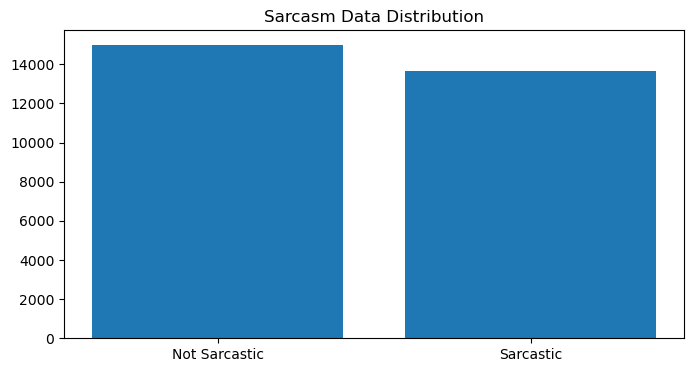

In [5]:
val_count = df.is_sarcastic.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sarcasm Data Distribution")

In [6]:
import random
random_idx_list = [random.randint(1,len(df.headline)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,is_sarcastic,headline
15447,Sarcastic,indian casino one of the saddest places on earth
14691,Sarcastic,fema unveils nationwide phone tree in case of ...
11861,Not Sarcastic,man who supplied guns to california shooters a...
558,Not Sarcastic,"mister rove, master of the smear"
1865,Not Sarcastic,survivalist sentenced to death for murder of p...
25024,Sarcastic,gratitude for thank-you note plunges friends i...
13563,Sarcastic,new ford pickup features extendable tailgate f...
3154,Sarcastic,'you thought you could get rid of me?' says ca...
19378,Sarcastic,richard simmons fighting for life in estrogen ...
19796,Not Sarcastic,"earth day is nearly here, but our planet is wo..."


In [7]:
stemmer = SnowballStemmer('english')

def decontracted(phrase):
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

<>:13: SyntaxWarning: invalid escape sequence '\S'
<>:13: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Kelvin\AppData\Local\Temp\ipykernel_22168\2477235340.py:13: SyntaxWarning: invalid escape sequence '\S'
  text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


In [8]:
def preprocess(text, stem=False):
  text = decontracted(text)
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if stem:
      tokens.append(stemmer.stem(token))
    else:
      tokens.append(token)
  return " ".join(tokens)

In [9]:
df.headline = df.headline.apply(lambda x: preprocess(x))

# Split & Train

In [10]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [11]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 22895
Test Data size 5724


In [12]:
train_data.head(10)

,is_sarcastic,headline
433,Sarcastic,experts caution new car loses 90 of value as s...
17842,Sarcastic,how could harvey weinstein get away with this ...
25394,Not Sarcastic,twitterverse trolls marco rubio over his fool ...
379,Not Sarcastic,russell simmons leads i am a muslim too rally ...
6495,Not Sarcastic,if this is what fall looks like sign us up
16203,Not Sarcastic,gluten free mania if you are following the fad...
22168,Sarcastic,follow your instructions this is all part of t...
22547,Not Sarcastic,a gay couple opens up about building their bea...
19872,Sarcastic,kathie lee gifford denies getting sincerity im...
7503,Not Sarcastic,erika christensen and cole maness are married


In [13]:
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.headline)

word_index = tokenizer.word_index
vocab_size = 300000
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 300000


In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.headline),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.headline),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (22895, 30)
Testing X Shape: (5724, 30)


In [15]:
labels = train_data.is_sarcastic.unique().tolist()

In [16]:
encoder = LabelEncoder()
encoder.fit(train_data.is_sarcastic.to_list())

y_train = encoder.transform(train_data.is_sarcastic.to_list())
y_test = encoder.transform(test_data.is_sarcastic.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (22895, 1)
y_test shape: (5724, 1)


https://nlp.stanford.edu/data/glove.6B.zip

In [17]:
GLOVE_EMB = 'E:/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [18]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [19]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [20]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

c:\Users\Kelvin\miniconda3\envs\ml\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [22]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = GlobalAveragePooling1D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [23]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [24]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.5882 - loss: 0.6647 - val_accuracy: 0.7479 - val_loss: 0.5170 - learning_rate: 0.0010
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7519 - loss: 0.5148 - val_accuracy: 0.7834 - val_loss: 0.4634 - learning_rate: 0.0010
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7867 - loss: 0.4545 - val_accuracy: 0.8084 - val_loss: 0.4163 - learning_rate: 0.0010
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8233 - loss: 0.3923 - val_accuracy: 0.8136 - val_loss: 0.4055 - learning_rate: 0.0010
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8449 - loss: 0.3513 - val_accuracy: 0.8356 - val_loss: 0.3660 - learning_rate: 0.0010
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8709 - loss: 0.3046 - val_accuracy: 0.8377 - val_loss: 0.3673 - learning_rate: 0.0010
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8882 - loss: 0.2702 - val_acc

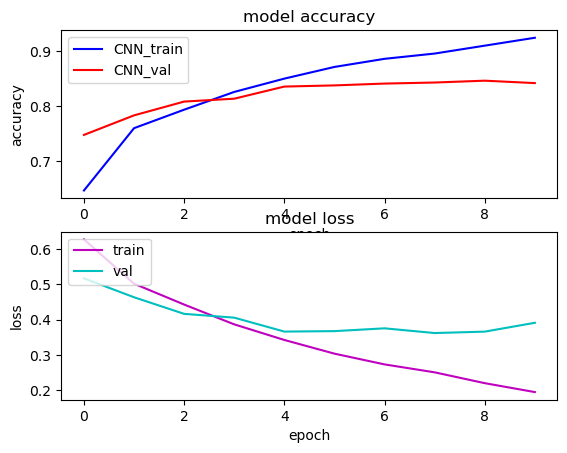

In [25]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['CNN_train', 'CNN_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [26]:
def decode_sarcasm(score):
    return "Sarcastic" if score>0.5 else "Not Sarcastic"

scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sarcasm(score) for score in scores]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


In [27]:
from sklearn.metrics import classification_report
print(classification_report(list(test_data.is_sarcastic), y_pred_1d))

               precision    recall  f1-score   support

Not Sarcastic       0.81      0.91      0.86      3025
    Sarcastic       0.89      0.76      0.82      2699

     accuracy                           0.84      5724
    macro avg       0.85      0.84      0.84      5724
 weighted avg       0.85      0.84      0.84      5724



In [28]:
import pickle
with open(r'E:/Research ML/CNN_SarcasmDetection.pkl', 'wb') as file:  
    pickle.dump(model, file)